$$\Large \text {Computer Assignment 5 - Implementing Neural Network with Tensorflow and Keras}$$

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import *
from tensorflow.keras.utils import *
from collections import Counter
import sys
import glob
from copy import deepcopy
import warnings
from keras.models import load_model
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

***
# Phase One: Preprocessing

In [3]:
!gdown --id 1AdJ0sGSwVrdtskKj27cjf1Q5Vi0zfP0Y

Downloading...
From: https://drive.google.com/uc?id=1AdJ0sGSwVrdtskKj27cjf1Q5Vi0zfP0Y
To: /content/dataset.zip
100% 894M/894M [00:15<00:00, 56.6MB/s]


In [4]:
!unzip /content/dataset.zip


  inflating: dataset/train/raven/410126f1b61e76c26e.jpg  
  inflating: dataset/train/raven/418365472123dee2ad.jpg  
  inflating: dataset/train/raven/421e75139b4b2621b7.jpg  
  inflating: dataset/train/raven/42590be26a47215477.jpg  
  inflating: dataset/train/raven/430c0fd87f6718f4d5.jpg  
  inflating: dataset/train/raven/43599b7d4e22504dab.jpg  
  inflating: dataset/train/raven/4653390357ae802c3a.jpg  
  inflating: dataset/train/raven/47e78eff31a1b5b7ad.jpg  
  inflating: dataset/train/raven/4821875ba7e3091de8.png  
  inflating: dataset/train/raven/489df24d3b2a0c2679.jpg  
  inflating: dataset/train/raven/49a48940ce17af6a17.jpg  
  inflating: dataset/train/raven/4a377e57c10ee1e18b.jpg  
  inflating: dataset/train/raven/4ac84a062ea82edfb3.jpg  
  inflating: dataset/train/raven/4b36680e32fb84e676.jpg  
  inflating: dataset/train/raven/4b3cdbd002f5845bd3.jpg  
  inflating: dataset/train/raven/4c3ae42401aa8b4957.jpg  
  inflating: dataset/train/raven/4f1faa1924eed114ef.jpg  
  inflating: 

In [5]:
def load_datasets(train_dir, test_dir, batch_size=32, img_height=100, 
                  img_width=100, scale=1/255.0, valid_ratio=0.3):

  dataGenerator = preprocessing.image.ImageDataGenerator(rescale=scale, validation_split=valid_ratio)

  print("train : ")
  train_ds = dataGenerator.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'grayscale',
    batch_size = batch_size,
    subset='training',
    shuffle = True
  )

  print("validation : ")
  valid_ds = dataGenerator.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    color_mode = 'grayscale',
    batch_size = batch_size,
    subset='validation',
    shuffle = True
  )

  dataGenerator = preprocessing.image.ImageDataGenerator(rescale=scale)

  print("test : ")
  test_ds = dataGenerator.flow_from_directory(
  test_dir,
  target_size = (img_height, img_width),
  batch_size = batch_size,
  color_mode = 'grayscale',
  class_mode = None,
  shuffle = False
  ) 

  return train_ds, valid_ds, test_ds

In [6]:
bald_eagle = glob.glob('/content/dataset/test/bald_eagle/*')
elk = glob.glob('/content/dataset/test/elk/*')
raccon = glob.glob('/content/dataset/test/racoon/*')
raven = glob.glob('/content/dataset/test/raven/*')

test_data = []
test_labels = []

for i in bald_eagle:   
    image = preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (100,100))
    image = np.array(image)
    test_data.append(image)
    test_labels.append(0)
for i in elk:   
    image = preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (100,100))
    image = np.array(image)
    test_data.append(image)
    test_labels.append(1)
for i in raccon:   
    image = preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (100,100))
    image = np.array(image)
    test_data.append(image)
    test_labels.append(2)
for i in raven:   
    image = preprocessing.image.load_img(i, color_mode='grayscale', 
    target_size= (100,100))
    image = np.array(image)
    test_data.append(image)
    test_labels.append(3)


test_data, test_labels = np.array(test_data), np.array(test_labels)
test_labels = to_categorical(test_labels, num_classes = 4)

In [7]:
train, valid, test = load_datasets(train_dir="/content/dataset/train", test_dir="/content/dataset/test")

train : 
Found 1363 images belonging to 4 classes.
validation : 
Found 582 images belonging to 4 classes.
test : 
Found 833 images belonging to 4 classes.


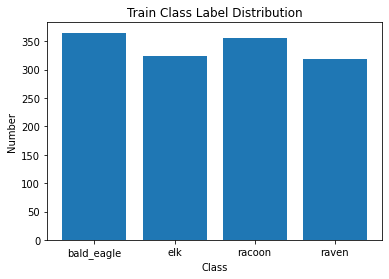

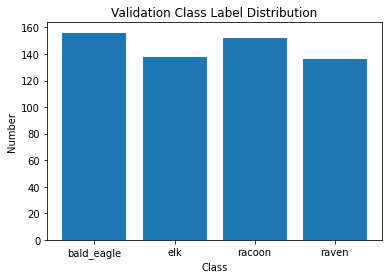

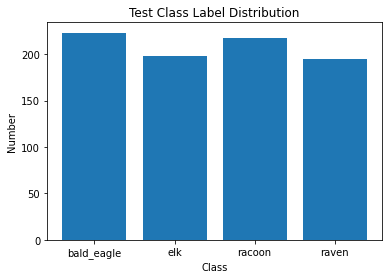

In [ ]:
for ds in [train, valid, test]:
  x = list(ds.class_indices.keys())
  y = list(dict(Counter(ds.classes)).values())

  plt.bar(x, y)
  plt.xlabel("Class")
  plt.ylabel("Number")
  if ds == train:
    plt.title("Train Class Label Distribution")
  elif ds == test:
    plt.title("Test Class Label Distribution")
  else:
    plt.title("Validation Class Label Distribution")
  plt.show()

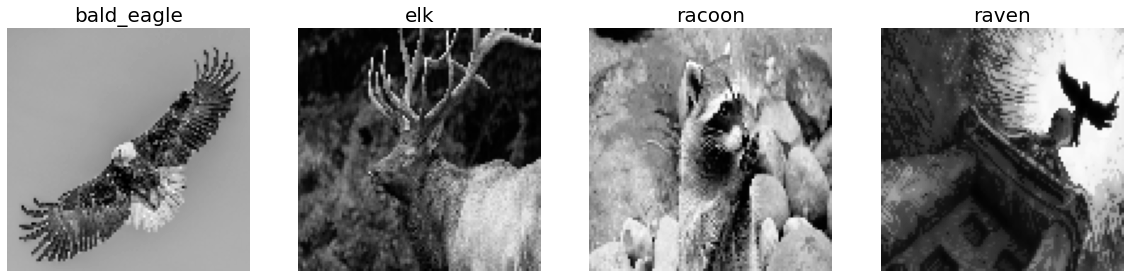

In [ ]:
indexes = []
plt.figure(figsize=(20, 20))
for images, labels in train:
  for i in range(len(labels)):
    index = [index for index, each_item in enumerate(labels[i]) if each_item][0]
    if index not in indexes:
      indexes.append(index)
    ax = plt.subplot(1, 4, index + 1)
    plt.imshow(images[i].reshape(100, 100), cmap='gray')
    plt.title(list(train.class_indices.keys())[index], fontsize=20)
    plt.axis("off")
    if len(indexes) == 4:
      break
  if len(indexes) == 4:
      break

## Why One-Hot Encoding?
In label encoding, each unique category value is assigned an integer value. The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

***
# Phase Two: Designing The Neural Network

In [10]:
print("train : ")
dataGenerator = preprocessing.image.ImageDataGenerator(rescale=1/255.0, validation_split=0.3)
train_dir="/content/dataset/train"
test_dir="/content/dataset/test"

train_ds = dataGenerator.flow_from_directory(
  train_dir,
  target_size = (100, 100),
  color_mode = 'grayscale',
  batch_size = 32,
  subset='training',
  shuffle = False
)

print("validation : ")
valid_ds = dataGenerator.flow_from_directory(
  train_dir,
  target_size = (100, 100),
  color_mode = 'grayscale',
  batch_size = 32,
  subset='validation',
  shuffle = False
)

print("test : ")
test_ds = dataGenerator.flow_from_directory(
  test_dir,
  target_size = (100, 100),
  color_mode = 'grayscale',
  batch_size = 32,
  subset='validation',
  shuffle = False
)

train : 
Found 1363 images belonging to 4 classes.
validation : 
Found 582 images belonging to 4 classes.
test : 
Found 248 images belonging to 4 classes.


In [9]:
def print_results(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Acuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  train_recall = history.history['recall']
  train_precision = history.history['precision']
  train_F1 = []
  for i in range(len(train_recall)):
    train_F1.append(2 * (train_recall[i] * train_precision[i]) / (train_recall[i] + train_precision[i]))

  val_recall = history.history['val_recall']
  val_precision = history.history['val_precision']
  val_F1 = []
  for i in range(len(val_recall)):
    val_F1.append(2 * (val_recall[i] * val_precision[i]) / (val_recall[i] + val_precision[i]))

  print("Train Recall:")
  print(train_recall)
  print("Train Precision:")
  print(train_precision)
  print("Train F1 Score:")
  print(train_F1)

  print("val Recall:")
  print(val_recall)
  print("val Precision:")
  print(val_precision)
  print("val F1 Score:")
  print(val_F1)

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

In [ ]:
model = models.Model(inputs=input, outputs=output)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
mcp_save = callbacks.ModelCheckpoint('/content/model/first_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 2048)              20482048  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 22,584,324
Trainable params: 22,584,324
Non-trainable params: 0
_________________________________________________________________


## The Number of Parameters
We have an input layer of size 10,000 which connects to the first hidden layer with 2048 neurons, which means we now have 10,000 * 2048 weight parameters and 2048 bias parameters. In the second hidden layer we have 1024 neurons, which means we have 2048 * 1024 weight parameters and 1024 bias parameters. In the output layer we have 4 neurons, which means we have 1024 * 4 weight parameters and 4 bias parameters.<br>
10,000 * 2048 + 2048 = 20,482,048<br>
2048 * 1024 + 1024 = 2,098,176<br>
1024 * 4 + 4 = 4100<br>
total : 22,584,324

***
# Phase Three: Data Classification

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 57s 1s/step - loss: 1.4854 - accuracy: 0.3558 - recall: 0.0924 - precision: 0.3290 - val_loss: 1.2051 - val_accuracy: 0.4725 - val_recall: 0.1615 - val_precision: 0.6267
Epoch 2/15
43/43 [==============================] - 58s 1s/step - loss: 1.2297 - accuracy: 0.4681 - recall: 0.1482 - precision: 0.5855 - val_loss: 1.3355 - val_accuracy: 0.4175 - val_recall: 0.2216 - val_precision: 0.4358
Epoch 3/15
43/43 [==============================] - 55s 1s/step - loss: 1.1269 - accuracy: 0.5165 - recall: 0.2135 - precision: 0.6962 - val_loss: 1.1500 - val_accuracy: 0.5206 - val_recall: 0.1615 - val_precision: 0.8103
Epoch 4/15
43/43 [==============================] - 54s 1s/step - loss: 1.0791 - accuracy: 0.5363 - recall: 0.2722 - precision: 0.7080 - val_loss: 1.1323 - val_accuracy: 0.5361 - val_recall: 0.1856 - val_precision: 0.7660
Epoch 5/15
43/43 [==============================] - 54s 1s/step - loss: 1.0479 - accuracy: 0.5745 - recall: 0.28

In [ ]:
model = load_model('/content/model/first_model.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.73      0.90      0.81       365
         elk       0.82      0.85      0.83       324
      racoon       0.94      0.85      0.90       355
       raven       0.93      0.76      0.84       319

    accuracy                           0.84      1363
   macro avg       0.86      0.84      0.84      1363
weighted avg       0.86      0.84      0.84      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.58      0.76      0.66       156
         elk       0.71      0.66      0.68       138
      racoon       0.76      0.71      0.73       152
       raven       0.83      0.63      0.72       136

    accuracy                           0.69       582
   macro avg       0.72      0.69      0.70       582
weighted avg       0.71      0.69      0.70       582



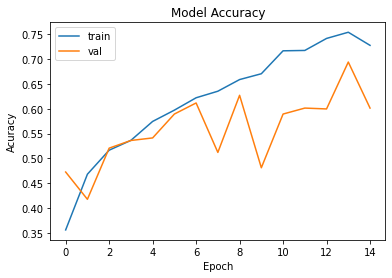

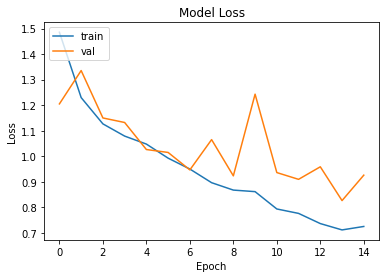

Train Recall:
[0.09244313836097717, 0.14820249378681183, 0.21349963545799255, 0.27219370007514954, 0.28319883346557617, 0.3316214084625244, 0.38738077878952026, 0.424064576625824, 0.4526779055595398, 0.47175347805023193, 0.5091709494590759, 0.5531914830207825, 0.5583271980285645, 0.5935436487197876, 0.6023477911949158]
Train Precision:
[0.3289817273616791, 0.5855072736740112, 0.6961722373962402, 0.7080152630805969, 0.7394636273384094, 0.7446457743644714, 0.7987897396087646, 0.7585301995277405, 0.789002537727356, 0.7938271760940552, 0.8126463890075684, 0.8322295546531677, 0.8418141603469849, 0.8615548610687256, 0.8343495726585388]
Train F1 Score:
[0.1443298951455013, 0.23653395916782347, 0.3267827077772898, 0.3932167556337006, 0.4095490832582733, 0.45888322981619245, 0.5217391371968342, 0.5440000148941356, 0.5752913613008511, 0.5918085584934507, 0.6260712753934188, 0.6646099474933181, 0.6713718419868776, 0.7028670737699053, 0.6996165439147497]
val Recall:
[0.16151203215122223, 0.2216494

In [ ]:
print_results(history)

***
## The effect of Optimizer

### What is momentum in SGD optimizer and why it is useful to use?
#### momentum is a float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations.<br>
#### SGD with momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging. <br>
#### With Stochastic Gradient Descent we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are ‘noisy’. What we want to do with this data is, instead of using it, we want some kind of ‘moving’ average which would ‘denoise’ the data and bring it closer to the original function. <br>
#### So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations. This is one reason why momentum might work better than classic SGD.

$$ \huge V_t = \beta V_{t-1} + (1 - \beta)\nabla_w L(W, X, y) $$ <br>
$$ \huge W = W - \alpha V_t $$

## Testing the network with SGD optimizer with momentum parameter equals to 0.5 and 0.9

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
mcp_save = callbacks.ModelCheckpoint('/content/model/model_with_0.5_momentum.hdf5', 
                                     save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 57s 1s/step - loss: 1.3696 - accuracy: 0.3749 - recall: 0.1189 - precision: 0.4723 - val_loss: 1.1694 - val_accuracy: 0.4588 - val_recall: 0.1254 - val_precision: 0.7849
Epoch 2/15
43/43 [==============================] - 55s 1s/step - loss: 1.1640 - accuracy: 0.4908 - recall: 0.2047 - precision: 0.6643 - val_loss: 1.0971 - val_accuracy: 0.5189 - val_recall: 0.2405 - val_precision: 0.7368
Epoch 3/15
43/43 [==============================] - 55s 1s/step - loss: 1.0964 - accuracy: 0.5356 - recall: 0.2627 - precision: 0.6704 - val_loss: 1.0868 - val_accuracy: 0.5275 - val_recall: 0.2440 - val_precision: 0.7172
Epoch 4/15
43/43 [==============================] - 54s 1s/step - loss: 1.0335 - accuracy: 0.5693 - recall: 0.3353 - precision: 0.7289 - val_loss: 1.1391 - val_accuracy: 0.4811 - val_recall: 0.3625 - val_precision: 0.6224
Epoch 5/15
43/43 [==============================] - 54s 1s/step - loss: 0.9874 - accuracy: 0.5928 - recall: 0.37

In [ ]:
model = load_model('/content/model/model_with_0.5_momentum.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.95      0.75      0.84       365
         elk       0.87      0.91      0.89       324
      racoon       0.95      0.93      0.94       355
       raven       0.77      0.94      0.84       319

    accuracy                           0.88      1363
   macro avg       0.89      0.88      0.88      1363
weighted avg       0.89      0.88      0.88      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.79      0.53      0.63       156
         elk       0.72      0.75      0.73       138
      racoon       0.79      0.74      0.76       152
       raven       0.60      0.85      0.71       136

    accuracy                           0.71       582
   macro avg       0.72      0.72      0.71       582
weighted avg       0.73      0.71      0.71       582



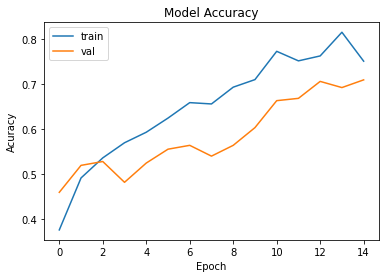

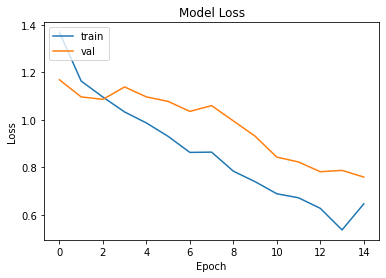

Train Recall:
[0.11885546892881393, 0.20469552278518677, 0.26265591382980347, 0.3352898061275482, 0.37197357416152954, 0.422597199678421, 0.4981658160686493, 0.49229639768600464, 0.5619956254959106, 0.5964783430099487, 0.6287600994110107, 0.6250917315483093, 0.661041796207428, 0.7336757183074951, 0.666911244392395]
Train Precision:
[0.47230321168899536, 0.6642857193946838, 0.670412003993988, 0.7288676500320435, 0.7423133254051208, 0.7480519413948059, 0.8083333373069763, 0.7703788876533508, 0.8080168962478638, 0.811377227306366, 0.8501983880996704, 0.8223938345909119, 0.838139533996582, 0.8968609571456909, 0.8189189434051514]
Train F1 Score:
[0.18991794096033196, 0.31295569112430377, 0.3774380710939087, 0.45929649161850267, 0.49560116143527777, 0.5400843763617077, 0.6164321432503076, 0.6007162025716971, 0.6629165117996062, 0.6875264115209919, 0.7229017278509234, 0.7102959754551955, 0.7391304198674382, 0.8071024919116628, 0.7351395281750065]
val Recall:
[0.12542955577373505, 0.2405498325

In [ ]:
print_results(history)

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
mcp_save = callbacks.ModelCheckpoint('/content/model/model_with_0.9_momentum.hdf5', 
                                     save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 58s 1s/step - loss: 1.7565 - accuracy: 0.2847 - recall: 0.0990 - precision: 0.2807 - val_loss: 1.3779 - val_accuracy: 0.2801 - val_recall: 0.0825 - val_precision: 0.3967
Epoch 2/15
43/43 [==============================] - 55s 1s/step - loss: 1.2717 - accuracy: 0.3830 - recall: 0.0976 - precision: 0.5859 - val_loss: 1.2133 - val_accuracy: 0.4502 - val_recall: 0.0945 - val_precision: 0.7143
Epoch 3/15
43/43 [==============================] - 55s 1s/step - loss: 1.1929 - accuracy: 0.4534 - recall: 0.1937 - precision: 0.6519 - val_loss: 1.2898 - val_accuracy: 0.3608 - val_recall: 0.1100 - val_precision: 0.7273
Epoch 4/15
43/43 [==============================] - 55s 1s/step - loss: 1.1499 - accuracy: 0.4718 - recall: 0.2414 - precision: 0.6502 - val_loss: 1.0948 - val_accuracy: 0.5086 - val_recall: 0.2199 - val_precision: 0.6919
Epoch 5/15
43/43 [==============================] - 54s 1s/step - loss: 1.1135 - accuracy: 0.4952 - recall: 0.26

In [ ]:
model = load_model('/content/model/model_with_0.9_momentum.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.70      0.64      0.66       365
         elk       0.93      0.48      0.63       324
      racoon       0.58      0.84      0.69       355
       raven       0.69      0.75      0.72       319

    accuracy                           0.68      1363
   macro avg       0.72      0.68      0.68      1363
weighted avg       0.72      0.68      0.68      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.53      0.46      0.49       156
         elk       0.81      0.30      0.44       138
      racoon       0.48      0.76      0.59       152
       raven       0.63      0.71      0.67       136

    accuracy                           0.56       582
   macro avg       0.61      0.56      0.55       582
weighted avg       0.61      0.56      0.55       582



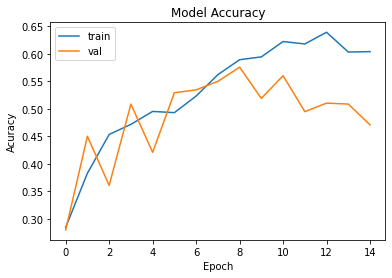

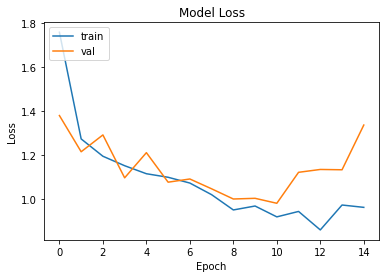

Train Recall:
[0.09904622286558151, 0.09757886826992035, 0.19369038939476013, 0.24137930572032928, 0.26412326097488403, 0.30080702900886536, 0.3235509991645813, 0.344093918800354, 0.4152604639530182, 0.4402054250240326, 0.4651504158973694, 0.4724871516227722, 0.5135729908943176, 0.4739544987678528, 0.4446074962615967]
Train Precision:
[0.2806652784347534, 0.5859031081199646, 0.6518518328666687, 0.6501976251602173, 0.6338028311729431, 0.6528662443161011, 0.6753445863723755, 0.701046347618103, 0.7092731595039368, 0.6952491402626038, 0.708379864692688, 0.7285068035125732, 0.7407407164573669, 0.6991341710090637, 0.7257484793663025]
Train F1 Score:
[0.14642082540708415, 0.16729559573217453, 0.298642532593946, 0.35205991969123196, 0.372863807051398, 0.41185332710059736, 0.437500012744002, 0.46161418282970534, 0.5238315602864712, 0.5390835576228139, 0.5615589032938291, 0.5732087210891511, 0.6065857735564811, 0.5649322069662348, 0.5514103760671581]
val Recall:
[0.0824742242693901, 0.0945017188

In [ ]:
print_results(history)

### Does the result always improve with increasing momentum?
No, because with increasing the momentum, we have smoother exponentially weighed averages which can be far from the actual value.

***
## Adam Optimizer

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

mcp_save = callbacks.ModelCheckpoint('/content/model/Adam_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 59s 1s/step - loss: 7.3922 - accuracy: 0.2722 - recall: 0.1988 - precision: 0.2805 - val_loss: 1.2897 - val_accuracy: 0.3797 - val_recall: 0.1512 - val_precision: 0.5500
Epoch 2/15
43/43 [==============================] - 55s 1s/step - loss: 1.3757 - accuracy: 0.3756 - recall: 0.1908 - precision: 0.4437 - val_loss: 1.2943 - val_accuracy: 0.4330 - val_recall: 0.2354 - val_precision: 0.6618
Epoch 3/15
43/43 [==============================] - 56s 1s/step - loss: 1.1620 - accuracy: 0.4468 - recall: 0.2311 - precision: 0.6164 - val_loss: 1.2075 - val_accuracy: 0.4244 - val_recall: 0.2251 - val_precision: 0.4596
Epoch 4/15
43/43 [==============================] - 56s 1s/step - loss: 1.1235 - accuracy: 0.5187 - recall: 0.2715 - precision: 0.6655 - val_loss: 1.0831 - val_accuracy: 0.5481 - val_recall: 0.2148 - val_precision: 0.7962
Epoch 5/15
43/43 [==============================] - 56s 1s/step - loss: 1.0769 - accuracy: 0.5224 - recall: 0.31

In [ ]:
model = load_model('/content/model/Adam_model.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.88      0.57      0.69       365
         elk       0.78      0.91      0.84       324
      racoon       0.82      0.89      0.86       355
       raven       0.72      0.82      0.77       319

    accuracy                           0.79      1363
   macro avg       0.80      0.80      0.79      1363
weighted avg       0.80      0.79      0.79      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.72      0.42      0.53       156
         elk       0.60      0.75      0.67       138
      racoon       0.64      0.66      0.65       152
       raven       0.65      0.76      0.70       136

    accuracy                           0.64       582
   macro avg       0.65      0.65      0.64       582
weighted avg       0.65      0.64      0.64       582



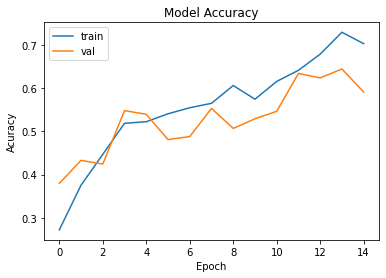

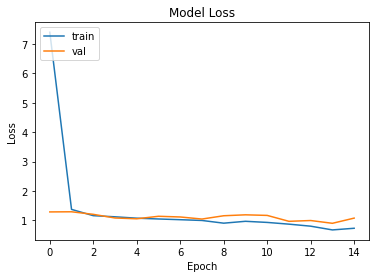

Train Recall:
[0.1988261193037033, 0.1907556802034378, 0.23110784590244293, 0.27146002650260925, 0.31254586577415466, 0.34702861309051514, 0.3602347671985626, 0.42039617896080017, 0.4607483446598053, 0.4269992709159851, 0.4607483446598053, 0.4930300712585449, 0.5539251565933228, 0.6441673040390015, 0.6221569776535034]
Train Precision:
[0.28053829073905945, 0.44368600845336914, 0.6164383292198181, 0.6654676198959351, 0.6656249761581421, 0.6875, 0.679114818572998, 0.6878751516342163, 0.7353630065917969, 0.7088915705680847, 0.7235022783279419, 0.7567567825317383, 0.7657200694084167, 0.8018264770507812, 0.7765567898750305]
Train F1 Score:
[0.23271790101716316, 0.2668034836060505, 0.3361792869329917, 0.38561752004644334, 0.42536196242219776, 0.4612384200510356, 0.47075742737344545, 0.5218579193848649, 0.5665313478660527, 0.532967029464873, 0.5629762326089077, 0.5970679708871665, 0.642826724935461, 0.7144019660162308, 0.6908350179731817]
val Recall:
[0.1512027531862259, 0.23539519309997559, 

In [ ]:
print_results(history)

***
## The effect of epoch number


### Why the neural networks are often trained in multiple epochs?
One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.<br>Generally whenever you want to optimize you use gradient descent. Gradient descent has a parameter called learning rate. In one iteration alone you can not guarantee that the gradient descent algorithm would converge to a local minima with the specified learning rate. That is the reason why you iterate again for the gradient descent to converge better.

### Is it necessary to train your network in multiple epochs?
It depends on the hardness level of the problem. Sometimes more epochs result in overfitting.

### Overfitting

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

In [ ]:
history = model.fit(train, validation_data=valid, epochs=25)

Epoch 1/25
43/43 [==============================] - 56s 1s/step - loss: 4.8443 - accuracy: 0.3287 - recall: 0.2333 - precision: 0.3302 - val_loss: 1.3737 - val_accuracy: 0.4158 - val_recall: 0.2526 - val_precision: 0.5632
Epoch 2/25
43/43 [==============================] - 54s 1s/step - loss: 1.2443 - accuracy: 0.4226 - recall: 0.1812 - precision: 0.5346 - val_loss: 1.2219 - val_accuracy: 0.4261 - val_recall: 0.1890 - val_precision: 0.6395
Epoch 3/25
43/43 [==============================] - 55s 1s/step - loss: 1.1530 - accuracy: 0.4828 - recall: 0.2531 - precision: 0.5990 - val_loss: 1.2232 - val_accuracy: 0.4622 - val_recall: 0.3677 - val_precision: 0.5768
Epoch 4/25
43/43 [==============================] - 54s 1s/step - loss: 1.1354 - accuracy: 0.4967 - recall: 0.3103 - precision: 0.5992 - val_loss: 1.1076 - val_accuracy: 0.4897 - val_recall: 0.2216 - val_precision: 0.7544
Epoch 5/25
43/43 [==============================] - 55s 1s/step - loss: 1.1276 - accuracy: 0.4842 - recall: 0.29

In [ ]:
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.71      0.98      0.82       365
         elk       0.99      0.88      0.93       324
      racoon       0.96      0.85      0.90       355
       raven       0.97      0.78      0.86       319

    accuracy                           0.87      1363
   macro avg       0.91      0.87      0.88      1363
weighted avg       0.90      0.87      0.88      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.49      0.87      0.63       156
         elk       0.83      0.53      0.65       138
      racoon       0.77      0.65      0.71       152
       raven       0.80      0.54      0.65       136

    accuracy                           0.65       582
   macro avg       0.72      0.65      0.66       582
weighted avg       0.72      0.65      0.66       582



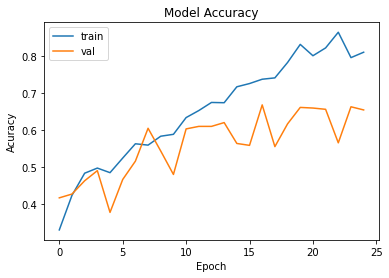

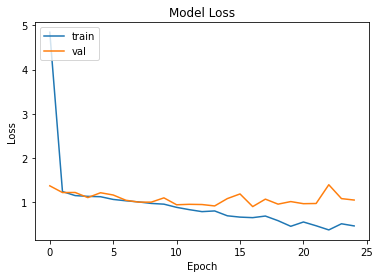

Train Recall:
[0.23330888152122498, 0.18121790885925293, 0.2531181275844574, 0.3103448152542114, 0.2912692725658417, 0.3316214084625244, 0.3785766661167145, 0.39545121788978577, 0.42920029163360596, 0.44680851697921753, 0.47909024357795715, 0.5267791748046875, 0.549523115158081, 0.5693323612213135, 0.6309611201286316, 0.6368305087089539, 0.6522377133369446, 0.6654438972473145, 0.7138664722442627, 0.7865003943443298, 0.7556859850883484, 0.7909024357795715, 0.8371239900588989, 0.7512839436531067, 0.7776962518692017]
Train Precision:
[0.3302180767059326, 0.5346320271492004, 0.5989583134651184, 0.5991501212120056, 0.621283233165741, 0.6429587602615356, 0.6692606806755066, 0.6848793029785156, 0.6890459656715393, 0.7147887349128723, 0.7378531098365784, 0.7581837177276611, 0.7635066509246826, 0.7504835724830627, 0.78899085521698, 0.7970615029335022, 0.815596342086792, 0.7914485335350037, 0.8337618112564087, 0.8830313086509705, 0.8477365970611572, 0.8735818266868591, 0.8907103538513184, 0.8271

In [ ]:
print_results(history)

### EarlyStopping

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=25, callbacks=[earlyStopping])

Epoch 1/25
43/43 [==============================] - 57s 1s/step - loss: 5.4109 - accuracy: 0.3236 - recall: 0.2304 - precision: 0.3355 - val_loss: 1.2130 - val_accuracy: 0.4450 - val_recall: 0.1048 - val_precision: 0.7722
Epoch 2/25
43/43 [==============================] - 55s 1s/step - loss: 1.2185 - accuracy: 0.4395 - recall: 0.2069 - precision: 0.5887 - val_loss: 1.1672 - val_accuracy: 0.4467 - val_recall: 0.2577 - val_precision: 0.7075
Epoch 3/25
43/43 [==============================] - 55s 1s/step - loss: 1.1703 - accuracy: 0.4644 - recall: 0.2502 - precision: 0.6223 - val_loss: 1.1037 - val_accuracy: 0.4897 - val_recall: 0.2474 - val_precision: 0.7385
Epoch 4/25
43/43 [==============================] - 55s 1s/step - loss: 1.1589 - accuracy: 0.4519 - recall: 0.2619 - precision: 0.5843 - val_loss: 1.1341 - val_accuracy: 0.4845 - val_recall: 0.2302 - val_precision: 0.7243
Epoch 5/25
43/43 [==============================] - 55s 1s/step - loss: 1.0775 - accuracy: 0.5128 - recall: 0.28

In [ ]:
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.85      0.35      0.49       365
         elk       0.70      0.73      0.71       324
      racoon       0.66      0.87      0.75       355
       raven       0.61      0.77      0.68       319

    accuracy                           0.67      1363
   macro avg       0.70      0.68      0.66      1363
weighted avg       0.71      0.67      0.65      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.68      0.23      0.34       156
         elk       0.62      0.64      0.63       138
      racoon       0.57      0.76      0.65       152
       raven       0.52      0.70      0.60       136

    accuracy                           0.58       582
   macro avg       0.60      0.58      0.56       582
weighted avg       0.60      0.58      0.55       582



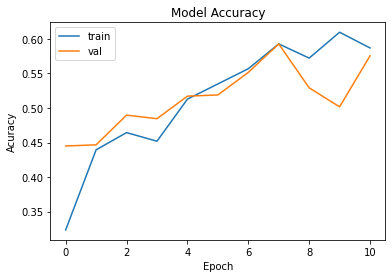

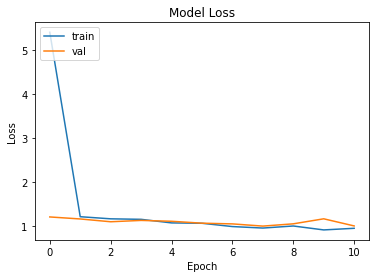

Train Recall:
[0.23037417232990265, 0.2068965584039688, 0.25018343329429626, 0.2619222402572632, 0.285399854183197, 0.31841525435447693, 0.3851797580718994, 0.4328686594963074, 0.42920029163360596, 0.44680851697921753, 0.4475421905517578]
Train Precision:
[0.3354700803756714, 0.5887265205383301, 0.6222627758979797, 0.5842880606651306, 0.6996402740478516, 0.6595744490623474, 0.7113820910453796, 0.699881374835968, 0.6778678894042969, 0.699999988079071, 0.7060185074806213]
Train F1 Score:
[0.2731622411589793, 0.30618893333876673, 0.3568812289975484, 0.3617021386720696, 0.40541948794011573, 0.42949034172886447, 0.4997620187974193, 0.534904795143551, 0.5256064636391535, 0.545454546560383, 0.5478221821303605]
val Recall:
[0.10481099784374237, 0.25773194432258606, 0.24742268025875092, 0.23024055361747742, 0.3625429570674896, 0.3161512017250061, 0.39003437757492065, 0.3814432919025421, 0.3487972617149353, 0.37457045912742615, 0.43986254930496216]
val Precision:
[0.7721518874168396, 0.707547187

In [ ]:
print_results(history)

### Is it always helpful to use more epochs?
No, sometimes more epochs will result to overfitting.<br>
We can avoid overfitting by stopping the training whenever we are going to overfit by using the early stopping method.

***
## The Effect of Loss Function

### MSE loss function

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='MSE', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

In [ ]:
history = model.fit(train, validation_data=valid, epochs=10)

Epoch 1/10
43/43 [==============================] - 58s 1s/step - loss: 0.3639 - accuracy: 0.2627 - recall: 0.2590 - precision: 0.2642 - val_loss: 0.3660 - val_accuracy: 0.2680 - val_recall: 0.2680 - val_precision: 0.2680
Epoch 2/10
43/43 [==============================] - 55s 1s/step - loss: 0.3661 - accuracy: 0.2678 - recall: 0.2678 - precision: 0.2678 - val_loss: 0.3660 - val_accuracy: 0.2680 - val_recall: 0.2680 - val_precision: 0.2680
Epoch 3/10
43/43 [==============================] - 55s 1s/step - loss: 0.3661 - accuracy: 0.2678 - recall: 0.2678 - precision: 0.2678 - val_loss: 0.3660 - val_accuracy: 0.2680 - val_recall: 0.2680 - val_precision: 0.2680
Epoch 4/10
43/43 [==============================] - 55s 1s/step - loss: 0.3661 - accuracy: 0.2678 - recall: 0.2678 - precision: 0.2678 - val_loss: 0.3660 - val_accuracy: 0.2680 - val_recall: 0.2680 - val_precision: 0.2680
Epoch 5/10
43/43 [==============================] - 55s 1s/step - loss: 0.3661 - accuracy: 0.2678 - recall: 0.26

In [ ]:
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.27      1.00      0.42       365
         elk       0.00      0.00      0.00       324
      racoon       0.00      0.00      0.00       355
       raven       0.00      0.00      0.00       319

    accuracy                           0.27      1363
   macro avg       0.07      0.25      0.11      1363
weighted avg       0.07      0.27      0.11      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.27      1.00      0.42       156
         elk       0.00      0.00      0.00       138
      racoon       0.00      0.00      0.00       152
       raven       0.00      0.00      0.00       136

    accuracy                           0.27       582
   macro avg       0.07      0.25      0.11       582
weighted avg       0.07      0.27      0.11       582



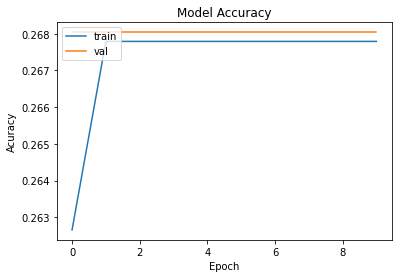

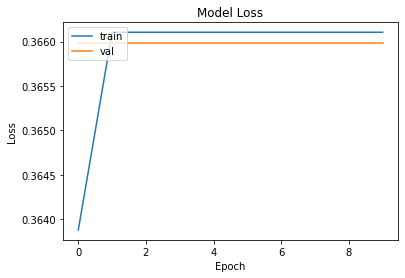

Train Recall:
[0.25898751616477966, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545]
Train Precision:
[0.26422154903411865, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545]
Train F1 Score:
[0.26157835272041086, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545, 0.26779162883758545]
val Recall:
[0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824]
val Precision:
[0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.2680412232875824, 0.268041223

In [ ]:
print_results(history)

### Why using MSE is not good in classification?
First, using MSE means that we assume that the underlying data has been generated from a normal distribution (a bell-shaped curve). While in reality, a dataset that can be classified into two categories (i.e binary) is not from a normal distribution but a Bernoulli distribution.<br>
Secondly, the MSE function is non-convex for binary classification. In simple terms, if a binary classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range(-∞, ∞), while binary classification models output probabilities in range(0,1) through the sigmoid/logistic function.

### When to use MSE?
When we are doing Linear Regression.

***
## The Effect of Regularization

#### L2 Regularization
A model that uses L2 is called Ridge Regression. Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. <br>L2 regularization can deal with the multicollinearity (independent variables are highly correlated) problems through constricting the coefficient and by keeping all the variables.


In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(output)
output = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(output)
output = layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

mcp_save = callbacks.ModelCheckpoint('/content/model/l2_reg_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 61s 1s/step - loss: 6.8673 - accuracy: 0.2781 - recall: 0.1651 - precision: 0.2641 - val_loss: 1.6586 - val_accuracy: 0.4467 - val_recall: 0.0893 - val_precision: 0.8387
Epoch 2/15
43/43 [==============================] - 58s 1s/step - loss: 1.6769 - accuracy: 0.4197 - recall: 0.1900 - precision: 0.5606 - val_loss: 1.5381 - val_accuracy: 0.5017 - val_recall: 0.1357 - val_precision: 0.8404
Epoch 3/15
43/43 [==============================] - 59s 1s/step - loss: 1.5553 - accuracy: 0.4806 - recall: 0.2370 - precision: 0.6605 - val_loss: 1.4931 - val_accuracy: 0.5137 - val_recall: 0.2732 - val_precision: 0.6653
Epoch 4/15
43/43 [==============================] - 59s 1s/step - loss: 1.4755 - accuracy: 0.4974 - recall: 0.2993 - precision: 0.6445 - val_loss: 1.4711 - val_accuracy: 0.5137 - val_recall: 0.2405 - val_precision: 0.6931
Epoch 5/15
43/43 [==============================] - 59s 1s/step - loss: 1.3766 - accuracy: 0.5591 - recall: 0.34

In [ ]:
model = load_model('/content/model/l2_reg_model.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.88      0.65      0.75       365
         elk       0.83      0.89      0.86       324
      racoon       0.89      0.86      0.87       355
       raven       0.71      0.90      0.79       319

    accuracy                           0.82      1363
   macro avg       0.83      0.83      0.82      1363
weighted avg       0.83      0.82      0.82      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.70      0.46      0.56       156
         elk       0.65      0.72      0.68       138
      racoon       0.76      0.66      0.70       152
       raven       0.58      0.82      0.68       136

    accuracy                           0.66       582
   macro avg       0.67      0.67      0.66       582
weighted avg       0.67      0.66      0.65       582



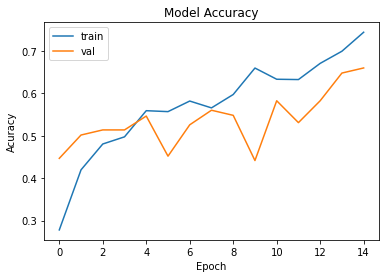

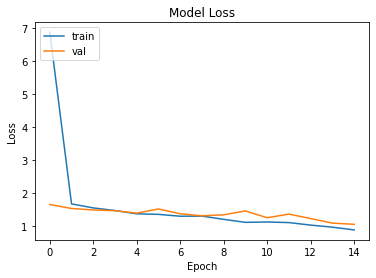

Train Recall:
[0.16507703065872192, 0.19002200663089752, 0.2369772493839264, 0.2993396818637848, 0.3411591947078705, 0.3602347671985626, 0.39985325932502747, 0.4262655973434448, 0.4490095376968384, 0.5341159105300903, 0.497432142496109, 0.5201760530471802, 0.5590608716011047, 0.5884079337120056, 0.6588407754898071]
Train Precision:
[0.26408451795578003, 0.560606062412262, 0.6605316996574402, 0.6445497870445251, 0.6888889074325562, 0.6744505763053894, 0.7096354365348816, 0.6819248795509338, 0.7320573925971985, 0.728728711605072, 0.7092050313949585, 0.7205284833908081, 0.7470588088035583, 0.7816764116287231, 0.8032200336456299]
Train F1 Score:
[0.20316027010257176, 0.28383561260856366, 0.34881208813104636, 0.4088176307813445, 0.45632972754283113, 0.46963175397754214, 0.5114969504237997, 0.5246049703291941, 0.5566166370195262, 0.6164267440443735, 0.5847348082244029, 0.6041755334825186, 0.6395299834355199, 0.6714106379830034, 0.7239016415041793]
val Recall:
[0.08934707939624786, 0.13573883

In [ ]:
print_results(history)

#### Dropout
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dropout(0.1)(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])

mcp_save = callbacks.ModelCheckpoint('/content/model/dropout_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 58s 1s/step - loss: 6.5649 - accuracy: 0.3015 - recall: 0.2186 - precision: 0.2992 - val_loss: 1.3104 - val_accuracy: 0.3814 - val_recall: 0.1546 - val_precision: 0.5422
Epoch 2/15
43/43 [==============================] - 56s 1s/step - loss: 1.2800 - accuracy: 0.3955 - recall: 0.1651 - precision: 0.5668 - val_loss: 1.1935 - val_accuracy: 0.4038 - val_recall: 0.1632 - val_precision: 0.6291
Epoch 3/15
43/43 [==============================] - 55s 1s/step - loss: 1.2229 - accuracy: 0.4189 - recall: 0.1878 - precision: 0.5899 - val_loss: 1.3095 - val_accuracy: 0.3935 - val_recall: 0.2165 - val_precision: 0.5020
Epoch 4/15
43/43 [==============================] - 55s 1s/step - loss: 1.1977 - accuracy: 0.4424 - recall: 0.2113 - precision: 0.5680 - val_loss: 1.1582 - val_accuracy: 0.4966 - val_recall: 0.1203 - val_precision: 0.7368
Epoch 5/15
43/43 [==============================] - 55s 1s/step - loss: 1.1201 - accuracy: 0.4776 - recall: 0.23

In [ ]:
model = load_model('/content/model/dropout_model.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.59      0.52      0.55       365
         elk       0.83      0.43      0.57       324
      racoon       0.64      0.75      0.69       355
       raven       0.58      0.84      0.69       319

    accuracy                           0.63      1363
   macro avg       0.66      0.64      0.63      1363
weighted avg       0.66      0.63      0.62      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.53      0.49      0.51       156
         elk       0.71      0.27      0.39       138
      racoon       0.53      0.63      0.58       152
       raven       0.54      0.82      0.65       136

    accuracy                           0.55       582
   macro avg       0.58      0.55      0.53       582
weighted avg       0.58      0.55      0.53       582



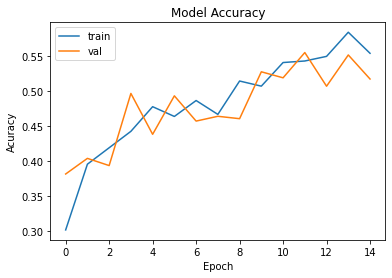

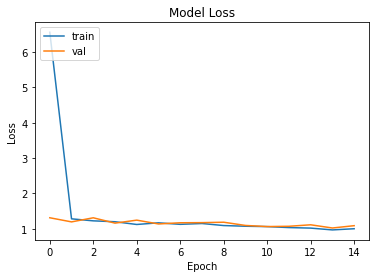

Train Recall:
[0.21863536536693573, 0.16507703065872192, 0.18782098591327667, 0.2112985998392105, 0.2362435758113861, 0.23110784590244293, 0.26338958740234375, 0.26705795526504517, 0.2942039668560028, 0.2949376404285431, 0.28906822204589844, 0.3367571532726288, 0.3484959602355957, 0.38664710521698, 0.3807776868343353]
Train Precision:
[0.2991967797279358, 0.5667506456375122, 0.5898617506027222, 0.5680473446846008, 0.6708333492279053, 0.5898876190185547, 0.6468468308448792, 0.6286700963973999, 0.6499189734458923, 0.6330708861351013, 0.6655405163764954, 0.6810088753700256, 0.6814920902252197, 0.6773778796195984, 0.6636828780174255]
Train F1 Score:
[0.2526494265451335, 0.25568181345435537, 0.28491931310463237, 0.3080213849000669, 0.3494302739280109, 0.3321033130652374, 0.3743482824315487, 0.37487125733880283, 0.4050505118785087, 0.40240240910736574, 0.4030690397542448, 0.45066273341596363, 0.46116504025409844, 0.4922933202234144, 0.4839160799123082]
val Recall:
[0.15463916957378387, 0.163

In [ ]:
print_results(history)

Because the network is small relative to the dataset, regularization is usually unnecessary. If the model capacity is already low, lowering it further by adding regularization will hurt performance.

***
## Best Combination

In [ ]:
backend.clear_session()
input = layers.Input(shape=(100, 100, 1))
output = layers.Flatten()(input)
output = layers.Dense(2048, activation='relu')(output)
output = layers.Dense(1024, activation='relu')(output)
output = layers.Dense(4, activation='softmax')(output)

model = models.Model(inputs=input, outputs=output)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
mcp_save = callbacks.ModelCheckpoint('/content/model/best_model.hdf5', 
                                     save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(train, validation_data=valid, epochs=20, callbacks=[mcp_save])

Epoch 1/20
43/43 [==============================] - 58s 1s/step - loss: 1.5901 - accuracy: 0.3683 - recall: 0.0778 - precision: 0.3655 - val_loss: 1.2053 - val_accuracy: 0.5000 - val_recall: 0.0704 - val_precision: 0.8723
Epoch 2/20
43/43 [==============================] - 55s 1s/step - loss: 1.1923 - accuracy: 0.4674 - recall: 0.1467 - precision: 0.6849 - val_loss: 1.1169 - val_accuracy: 0.5309 - val_recall: 0.1667 - val_precision: 0.8151
Epoch 3/20
43/43 [==============================] - 55s 1s/step - loss: 1.1174 - accuracy: 0.5275 - recall: 0.2348 - precision: 0.7191 - val_loss: 1.0652 - val_accuracy: 0.5533 - val_recall: 0.2148 - val_precision: 0.8013
Epoch 4/20
43/43 [==============================] - 54s 1s/step - loss: 1.0691 - accuracy: 0.5451 - recall: 0.2905 - precision: 0.7333 - val_loss: 1.1291 - val_accuracy: 0.4656 - val_recall: 0.3196 - val_precision: 0.5905
Epoch 5/20
43/43 [==============================] - 55s 1s/step - loss: 1.0175 - accuracy: 0.5796 - recall: 0.34

In [ ]:
model = load_model('/content/drive/MyDrive/model/best_model.hdf5')
print("TRAIN : ")
pred = np.argmax(model.predict(train_ds), axis=1)
print(classification_report(train_ds.classes, pred, target_names=train_ds.class_indices))
print("VALIDATION : ")
pred = np.argmax(model.predict(valid_ds), axis=1)
print(classification_report(valid_ds.classes, pred, target_names=valid_ds.class_indices))

TRAIN : 
              precision    recall  f1-score   support

  bald_eagle       0.93      0.85      0.89       365
         elk       0.96      0.94      0.95       324
      racoon       0.98      0.95      0.96       355
       raven       0.83      0.96      0.89       319

    accuracy                           0.92      1363
   macro avg       0.92      0.92      0.92      1363
weighted avg       0.93      0.92      0.92      1363

VALIDATION : 
              precision    recall  f1-score   support

  bald_eagle       0.75      0.59      0.66       156
         elk       0.76      0.70      0.73       138
      racoon       0.77      0.77      0.77       152
       raven       0.64      0.85      0.73       136

    accuracy                           0.72       582
   macro avg       0.73      0.73      0.72       582
weighted avg       0.73      0.72      0.72       582



In [ ]:
model = load_model('/content/drive/MyDrive/model/best_model.hdf5')

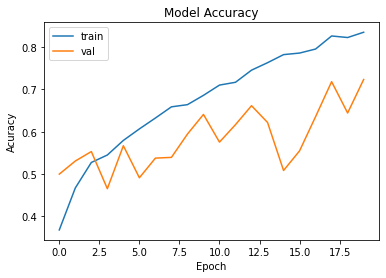

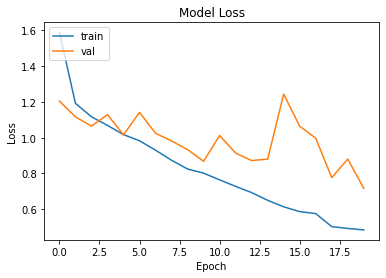

Train Recall:
[0.07776962220668793, 0.14673514664173126, 0.23477622866630554, 0.290535569190979, 0.34189289808273315, 0.365370512008667, 0.41746148467063904, 0.45414528250694275, 0.5055025815963745, 0.5377842783927917, 0.5685986876487732, 0.603081464767456, 0.624358057975769, 0.6603081226348877, 0.6859868168830872, 0.6947908997535706, 0.7153338193893433, 0.7578870058059692, 0.7586206793785095, 0.7806309461593628]
Train Precision:
[0.3655172288417816, 0.6849315166473389, 0.7191011309623718, 0.7333333492279053, 0.7338582873344421, 0.7421758770942688, 0.7710027098655701, 0.8007761836051941, 0.7811791300773621, 0.7993456721305847, 0.8039419054985046, 0.8146679997444153, 0.8310546875, 0.831792950630188, 0.8500000238418579, 0.8516187071800232, 0.8567662835121155, 0.8882201313972473, 0.8703703880310059, 0.8815244436264038]
Train F1 Score:
[0.12825165794937013, 0.2416918483598223, 0.3539823015041295, 0.41618495921074494, 0.4664664841461539, 0.48967552579725293, 0.541646837027635, 0.57958802355

In [ ]:
print_results(history)

In [ ]:
pred = np.argmax(model.predict(test), axis=1)
print(classification_report(test.classes, pred, target_names=test.class_indices))

              precision    recall  f1-score   support

  bald_eagle       0.73      0.64      0.68       223
         elk       0.76      0.72      0.74       198
      racoon       0.76      0.72      0.74       217
       raven       0.66      0.83      0.74       195

    accuracy                           0.73       833
   macro avg       0.73      0.73      0.73       833
weighted avg       0.73      0.73      0.72       833



### Showing 10 images which correctly predicted and 10 images which are not

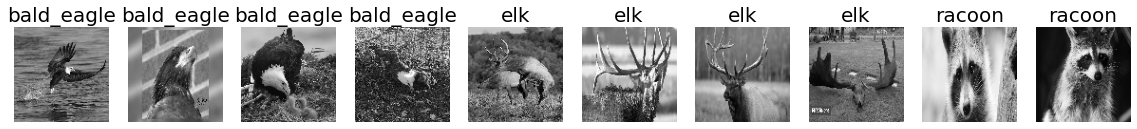

In [ ]:
class_num = [0, 0, 0, 0]
pred_index = 0
no = 0
indexes = []
plt.figure(figsize=(20, 20))
for images, labels in valid_ds:
  for i in range(len(labels)):
    index = [index for index, each_item in enumerate(labels[i]) if each_item][0]
    
    if index == pred[pred_index]:
      if class_num[index] >= 4:
        continue
      class_num[index] += 1
      if no >= 10:
        break
      ax = plt.subplot(1, 10, no + 1)
      plt.imshow(images[i].reshape(100, 100), cmap='gray')
      plt.title(list(valid_ds.class_indices.keys())[index], fontsize=20)
      plt.axis("off")
      no += 1
    pred_index += 1
      
    if no >= 10:
        break
  if no >= 10:
        break

Actual : racoon
Predicted : bald_eagle
Actual : racoon
Predicted : bald_eagle
Actual : racoon
Predicted : elk
Actual : racoon
Predicted : elk
Actual : raven
Predicted : bald_eagle
Actual : raven
Predicted : bald_eagle
Actual : raven
Predicted : elk
Actual : raven
Predicted : bald_eagle
Actual : bald_eagle
Predicted : racoon
Actual : bald_eagle
Predicted : racoon


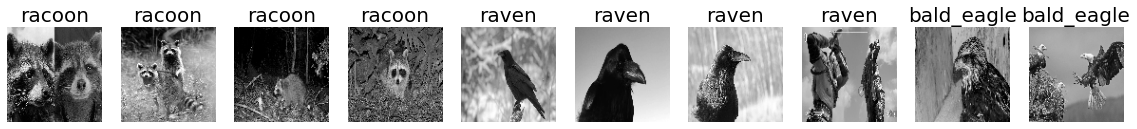

In [ ]:
class_num = [0, 0, 0, 0]
pred_index = 0
no = 0
indexes = []
plt.figure(figsize=(20, 20))
for images, labels in valid_ds:
  for i in range(len(labels)):
    index = [index for index, each_item in enumerate(labels[i]) if each_item][0]
    if index != pred[pred_index]:
      if class_num[index] >= 4:
        continue
      class_num[index] += 1
      if no >= 10:
        break
      ax = plt.subplot(1, 10, no + 1)
      plt.imshow(images[i].reshape(100, 100), cmap='gray')
      print("Actual : " + list(valid_ds.class_indices.keys())[index] + "\nPredicted : " + list(valid_ds.class_indices.keys())[pred[pred_index]])
      # plt.title(list(valid_ds.class_indices.keys())[index], fontsize=20)
      plt.title(list(test.class_indices.keys())[index], fontsize=20)
      plt.axis("off")
      no += 1
    pred_index += 1
      
    if no >= 10:
        break
  if no >= 10:
        break

One reason that this process will predict wrongly, is that the images are similar to each other and the network can't completely decide an image is belongs to what class.<br>
Also we can see that images that have two animals, can't be predicted well!

***
# Phase Five: Plotting Data With Reduced Dimension

In [13]:
backend.clear_session()
encoder_inputs = layers.Input(shape = (100, 100, 1))
flatted_input = layers.Flatten()(encoder_inputs)
hidden_layer_1 = layers.Dense(2048, activation='relu')(flatted_input)
hidden_layer_2 = layers.Dense(1024, activation='relu')(hidden_layer_1)
one_left_output = layers.Dense(2, activation='linear')(hidden_layer_2)
output = layers.Dense(4, activation='softmax')(hidden_layer_2)
encoder = Model(encoder_inputs,one_left_output)
model = Model(encoder_inputs, output)

batch_size = 32
# n_epoch = 10
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss='categorical_crossentropy',
              metrics=['accuracy', metrics.Recall(), metrics.Precision()])
mcp_save = callbacks.ModelCheckpoint('/content/model/best_plot.hdf5', 
                                     save_best_only=True, monitor='val_loss', mode='min')

model.fit(train, validation_data=valid, epochs=15, callbacks=[mcp_save])

Epoch 1/15
43/43 [==============================] - 59s 1s/step - loss: 1.4968 - accuracy: 0.3331 - recall: 0.0866 - precision: 0.3758 - val_loss: 1.2529 - val_accuracy: 0.4261 - val_recall: 0.1598 - val_precision: 0.6503
Epoch 2/15
43/43 [==============================] - 56s 1s/step - loss: 1.1969 - accuracy: 0.4644 - recall: 0.1526 - precision: 0.6933 - val_loss: 1.1944 - val_accuracy: 0.4983 - val_recall: 0.2027 - val_precision: 0.6941
Epoch 3/15
43/43 [==============================] - 56s 1s/step - loss: 1.1113 - accuracy: 0.5304 - recall: 0.2282 - precision: 0.7216 - val_loss: 1.2133 - val_accuracy: 0.4742 - val_recall: 0.2595 - val_precision: 0.6453
Epoch 4/15
43/43 [==============================] - 57s 1s/step - loss: 1.0583 - accuracy: 0.5583 - recall: 0.2825 - precision: 0.7375 - val_loss: 1.1377 - val_accuracy: 0.4948 - val_recall: 0.2904 - val_precision: 0.6213
Epoch 5/15
43/43 [==============================] - 56s 1s/step - loss: 1.0079 - accuracy: 0.5693 - recall: 0.34

In [11]:
model = load_model('/content/drive/MyDrive/model/best_plot.hdf5')

In [14]:
train_pred = encoder.predict(train_ds)
valid_pred = encoder.predict(valid_ds)
test_pred = encoder.predict(test_ds)

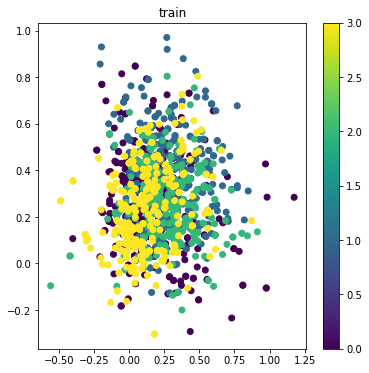

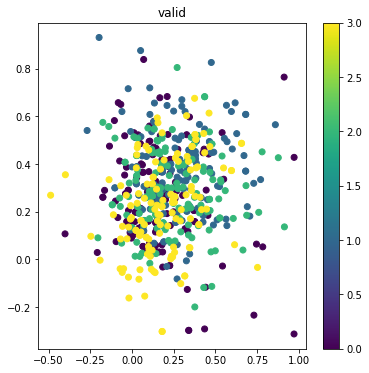

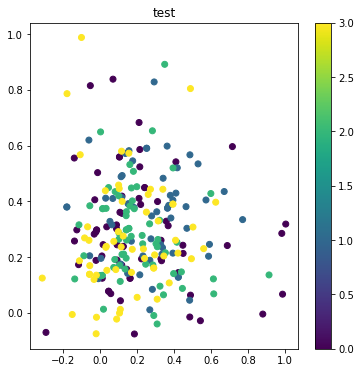

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(train_pred[:, 0], train_pred[:, 1], c=train_ds.classes)
plt.colorbar()
plt.title("train")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(valid_pred[:, 0], valid_pred[:, 1], c=valid_ds.classes)
plt.colorbar()
plt.title("valid")
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(test_pred[:, 0], test_pred[:, 1], c=test_ds.classes)
plt.colorbar()
plt.title("test")
plt.show()

In [ ]:
valid_ds.class_indices

{'bald_eagle': 0, 'elk': 1, 'racoon': 2, 'raven': 3}

Each of these colored clusters is a type of animal. Close clusters are animals that are similar. We can see that bald eagle datas are more compared to the other classes. So recognizing it from other classes is harder.<br>Based on the above plot and the F1 accuracy we obtained in the best model part, we can say that elk and raven are well separated.


***
# Conclusion

The steps that we should go through to build a neural network model:<br>
1- **Preprocess and load data:** Data is the key for the working of neural network and we need to process it before feeding to the neural network. In this step, we will also visualize data which will help us to gain insight into the data.<br>
2- **Define model:** This means we need to specify the number of hidden layers in the neural network and their size, the input and output size.<br>
3- **Loss and optimizer:** Now we need to define the loss function according to our task. We also need to specify the optimizer to use with learning rate and other hyperparameters of the optimizer.<br>
4- **Fit model:** This is the training step of the neural network. Here we need to define the number of epochs for which we need to train the neural network.